# Using `matplotlib` to display inline images

在这款笔记本中，我们将探索使用matplotlib在我们的笔记本中显示图像，并致力于开发可重复使用的功能，以显示SimpleITK图像的2D，3D，颜色和标签叠加。

我们还将研究使用图像滤镜的细微之处，这些滤镜需要输入图像重叠。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Download data to work on
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

SimpleITK有一个内置的`Show`方法，可以将图像保存到磁盘并启动用户可配置的程序（默认为ImageJ），以显示图像。

In [2]:
img1 = sitk.ReadImage(fdata("cthead1.png"))
img2 = sitk.ReadImage(fdata("VM1111Shrink-RGB.png"))

Fetching cthead1.png
Fetching VM1111Shrink-RGB.png


In [ ]:
sitk.Show(img1, title="cthead1")

In [ ]:
sitk.Show(img2, title="Visible Human Head")

img1_size:(256, 256),img1_channels:1
shape:(256, 256)
ndim:2


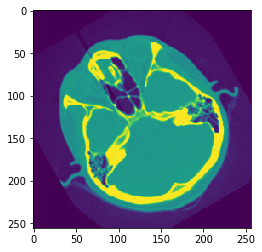

In [13]:
print("img1_size:{},img1_channels:{}".format(img1.GetSize(),img1.GetNumberOfComponentsPerPixel()))

#通道数为1的图像，转化为numpy数组后，通道维度消失
nda1 = sitk.GetArrayViewFromImage(img1)
print("shape:{}".format(nda1.shape))
print("ndim:{}".format(nda1.ndim))
plt.imshow(nda1)

img2_size:(297, 371),img2_channels:3
shape:(371, 297, 3)
ndim:3


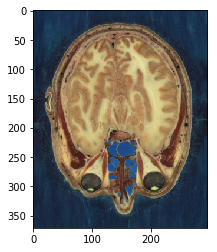

In [12]:
print("img2_size:{},img2_channels:{}".format(img2.GetSize(),img2.GetNumberOfComponentsPerPixel()))

#通道数为3的图像，转化为numpy数组后，通道维度在shape的最后1维
nda2 = sitk.GetArrayViewFromImage(img2)
print("shape:{}".format(nda2.shape))
print("ndim:{}".format(nda2.ndim))
ax = plt.imshow(nda2)

In [6]:
def myshow(img):
    nda = sitk.GetArrayViewFromImage(img)
    plt.imshow(nda)

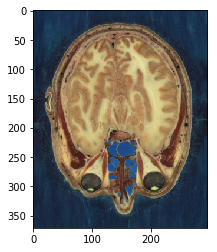

In [7]:
myshow(img2)

In [9]:
help(sitk.Expand)

Help on function Expand in module SimpleITK.SimpleITK:

Expand(*args, **kwargs)
    Expand(Image image1, VectorUInt32 expandFactors, itk::simple::InterpolatorEnum interpolator) -> Image
    
    
    
    Expand the size of an image by an integer factor in each dimension.
    
    
    This function directly calls the execute method of ExpandImageFilter in order to support a procedural API
    
    
    See:
     itk::simple::ExpandImageFilter for the object oriented interface



### Expand(Image image1, VectorUInt32 expandFactors, itk::simple::InterpolatorEnum interpolator)

在每个维度中按整数因子expandFactors扩展图像的大小。

[10, 10, 10, 10, 10]
img_expanded_size:(2970, 3710),img_expanded_channels:3


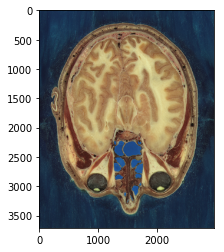

In [11]:
print([10]*5)
img_expanded=sitk.Expand(img2, [10]*5)
print("img_expanded_size:{},img_expanded_channels:{}".format(img_expanded.GetSize(),img_expanded.GetNumberOfComponentsPerPixel()))
myshow(img_expanded)

此图像看起来并没有更大。

我们可以做出许多改进：

- 支持3d图像
- 包括标题
- 使用物理像素大小的轴标签
- 将图像显示为灰色值

In [14]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
    
    #[H,W,C]/[y,x,C]
    #[D,H,W]/[z,y,x]
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # 最后的维数为3/4被认为是一个RGB图像
        #如果不是，则认为是3D图像[D,H,W]/[z,y,x]
        if not c in (3,4):
            #取中间depth深度的2D图像
            nda = nda[nda.shape[0]//2,:,:]
    
    #[D,H,W,C]/[z,y,x,C]
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
        
        #通道数为3或4，具有多通道(RGB)的3D图像    
        # take a z-slice
        #在每个通道上取某个depth深度的2D RGB图像
        nda = nda[nda.shape[0]//2,:,:,:]
            
    #高度，宽度
    hsize = nda.shape[0]
    wsize = nda.shape[1]
      
    # 使一个figure大到足以容纳ypixels的xpixels轴以及ticklabels等...
    figsize = (1 + margin) * hsize / dpi, (1 + margin) * wsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, wsize*spacing[1], hsize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    #[H,W]/[y,x]
    #通道数为1的2D灰度图像
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

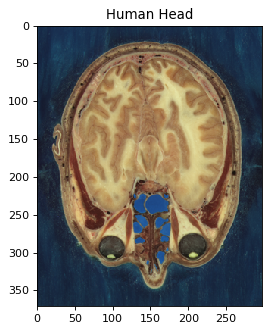

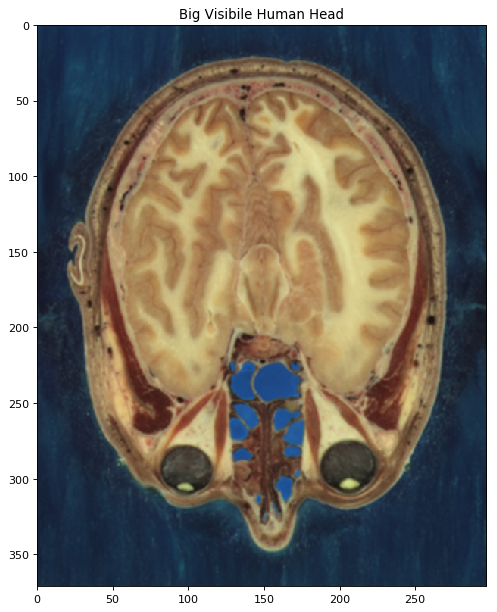

In [17]:
myshow(img2, title="Human Head")
myshow(sitk.Expand(img2,[2,2]), title="Big Visibile Human Head")

## 可视化分割图的提示和技巧

我们首先加载分割图像。 由于分割图只是一个带有整数数据的图像，我们可以像任何其他图像一样显示标签。

Fetching 2th_cthead1.png
img1_seg_size:(256, 256),img1_seg_channels:1


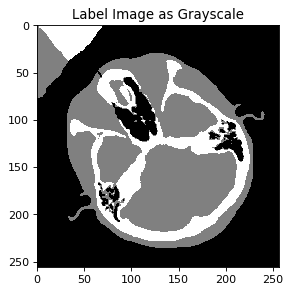

In [19]:
img1_seg = sitk.ReadImage(fdata("2th_cthead1.png"))

print("img1_seg_size:{},img1_seg_channels:{}".format(img1_seg.GetSize(),img1_seg.GetNumberOfComponentsPerPixel()))
myshow(img1_seg, "Label Image as Grayscale")

我们还可以将标量label image映射到彩色图像，如下所示。

### sitk.LabelToRGB()

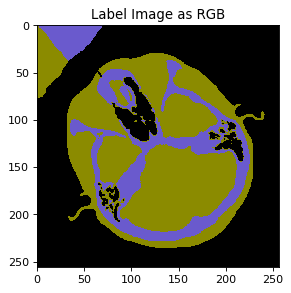

In [20]:
myshow(sitk.LabelToRGB(img1_seg), title="Label Image as RGB")

**将多个图像作为参数的大多数filter要求图像占据相同的物理空间。** 也就是说您正在操作的像素必须引用相同的位置。 幸运的是，我们的图像和标签确实占据了相同的物理空间，允许我们将分割叠加到原始图像上。

### sitk.LabelOverlay

In [23]:
help(sitk.LabelOverlay)
help(sitk.LabelContour)

Help on function LabelOverlay in module SimpleITK.SimpleITK:

LabelOverlay(*args, **kwargs)
    LabelOverlay(Image image, Image labelImage, double opacity=0.5, double backgroundValue=0.0, VectorUInt8 colormap) -> Image
    
    
    
    Apply a colormap to a label image and put it on top of the input
    image.
    
    
    This function directly calls the execute method of LabelOverlayImageFilter in order to support a procedural API
    
    
    See:
     itk::simple::LabelOverlayImageFilter for the object oriented interface

Help on function LabelContour in module SimpleITK.SimpleITK:

LabelContour(image1, fullyConnected=False, backgroundValue=0)
    LabelContour(Image image1, bool fullyConnected=False, double backgroundValue=0) -> Image
    
    
    
    Labels the pixels on the border of the objects in a labeled image.
    
    
    This function directly calls the execute method of LabelContourImageFilter in order to support a procedural API
    
    
    See:
     itk::simple

In [ ]:
myshow(sitk.LabelOverlay(img1, img1_seg), title="Label Overlayed")

我们还可以将标签覆盖为轮廓。
sitk.LabelContour:获取label图像轮廓上的像素

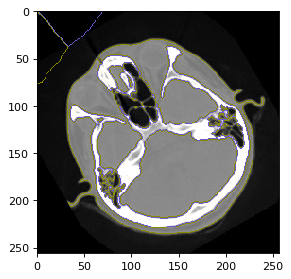

In [21]:
myshow(sitk.LabelOverlay(img1, sitk.LabelContour(img1_seg), opacity=1.0))

## 3D图像可视化的提示和技巧

现在让我们继续使用分割图来可视化真实的MRI图像。 布里格姆妇女医院的外科计划实验室提供了一个我们可以使用的基于多模态MRI的大脑图谱。

请注意，这里所做的是为了方便，并不是放射图像显示的常见方式。

In [30]:
img_T1 = sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT1.nrrd"))
img_T2 = sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT2.nrrd"))
img_labels = sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/hncma-atlas.nrrd"))

Fetching nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT1.nrrd
Fetching nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT2.nrrd
Fetching nac-hncma-atlas2013-Slicer4Version/Data/hncma-atlas.nrrd


In [31]:
print("img_T1_size:{},img_T1_channels:{}".format(img_T1.GetSize(),img_T1.GetNumberOfComponentsPerPixel()))
nda_T1 = sitk.GetArrayViewFromImage(img_T1)
print("shape:{}".format(nda_T1.shape))

print("img_T2_size:{},img_T2_channels:{}".format(img_T2.GetSize(),img_T2.GetNumberOfComponentsPerPixel()))
nda_T2 = sitk.GetArrayViewFromImage(img_T2)
print("shape:{}".format(nda_T2.shape))

print("img_labels_size:{},img_labels_channels:{}".format(img_labels.GetSize(),img_labels.GetNumberOfComponentsPerPixel()))
nda_labels = sitk.GetArrayViewFromImage(img_labels)
print("shape:{}".format(nda_labels.shape))

img_T1_size:(288, 320, 208),img_T1_channels:1
shape:(208, 320, 288)
img_T2_size:(288, 320, 208),img_T2_channels:1
shape:(208, 320, 288)
img_labels_size:(256, 256, 256),img_labels_channels:1
shape:(256, 256, 256)


RGB_img_labels_size:(256, 256, 256),RGB_img_labels_channels:3


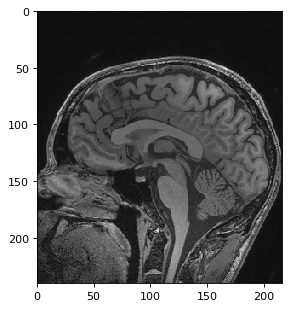

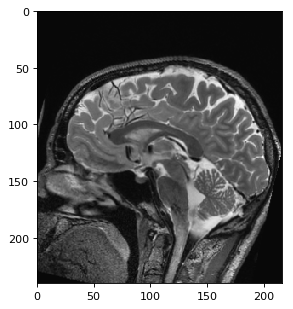

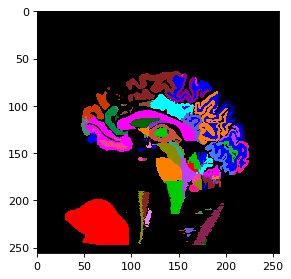

In [33]:
#取3D图像img_T1，img_T2，中间depth深度的2D图像显示
myshow(img_T1)
myshow(img_T2)

#RGB_img_labels:是有RGB三个通道的3D图像
#取3D 多通道(RGB)图像RGB_img_labels中间depth深度的2D多通道(RGB)图像显示
RGB_img_labels=sitk.LabelToRGB(img_labels)
print("RGB_img_labels_size:{},RGB_img_labels_channels:{}".
      format(RGB_img_labels.GetSize(),RGB_img_labels.GetNumberOfComponentsPerPixel()))
myshow(RGB_img_labels)

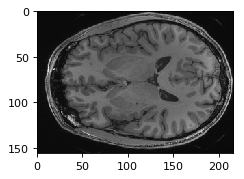

In [36]:
#对3D图像在height维度切片一张2Dslice
size = img_T1.GetSize()
myshow(img_T1[:,size[1]//2,:])

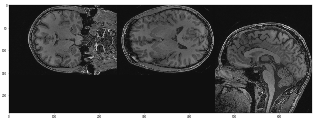

In [37]:
##对3D图像在分别在width,height,depth维度切片一张2Dslice
slices =[img_T1[size[0]//2,:,:], img_T1[:,size[1]//2,:], img_T1[:,:,size[2]//2]]
myshow(sitk.Tile(slices, [3,1]), dpi=20)

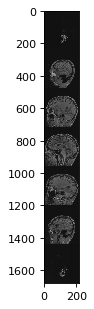

In [39]:
nslices = 5
#从depth=0开始切片,每隔size[2]//(nslices+1)深度切一片，共切5+2片2D slice
slices = [ img_T1[:,:,s] for s in range(0, size[2], size[2]//(nslices+1))]
myshow(sitk.Tile(slices, [1,0]))

让我们创建一个show方法的版本，它允许选择要显示的切片。

In [40]:
def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    size = img.GetSize()
    img_xslices = [img[s,:,:] for s in xslices]
    img_yslices = [img[:,s,:] for s in yslices]
    img_zslices = [img[:,:,s] for s in zslices]
    
    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))
    
        
    img_null = sitk.Image([0,0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())
    
    img_slices = []
    d = 0
    
    if len(img_xslices):
        img_slices += img_xslices + [img_null]*(maxlen-len(img_xslices))
        d += 1
        
    if len(img_yslices):
        img_slices += img_yslices + [img_null]*(maxlen-len(img_yslices))
        d += 1
     
    if len(img_zslices):
        img_slices += img_zslices + [img_null]*(maxlen-len(img_zslices))
        d +=1
    
    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen,d])
        #TO DO check in code to get Tile Filter working with vector images
        else:
            img_comps = []
            for i in range(0,img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen,d]))
            img = sitk.Compose(img_comps)
            
    
    myshow(img, title, margin, dpi)


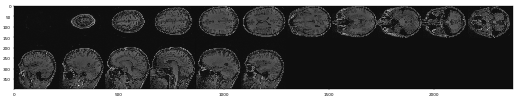

In [41]:
myshow3d(img_T1,yslices=range(50,size[1]-50,20), zslices=range(50,size[2]-50,20), dpi=30)

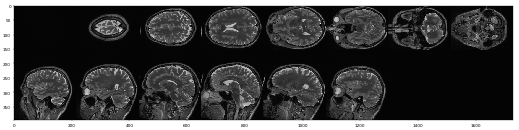

In [42]:
myshow3d(img_T2,yslices=range(50,size[1]-50,30), zslices=range(50,size[2]-50,20), dpi=30)

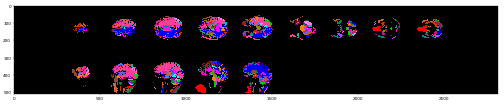

In [43]:
myshow3d(sitk.LabelToRGB(img_labels),yslices=range(50,size[1]-50,20), zslices=range(50,size[2]-50,20), dpi=30)

接下来，我们显示使用叠加了标签的T1图像。

In [ ]:
# Why doesn't this work? The images do overlap in physical space.
myshow3d(sitk.LabelOverlay(img_T1,img_labels),yslices=range(50,size[1]-50,20), zslices=range(50,size[2]-50,20), dpi=30)

解决问题的两种方法：
- (1)将标签重新取样到图像网格上
- (2)将图像重新取样到标签网格上。 

从计算的角度来看，两者之间的差异取决于网格大小和用于估计非网格位置处的值的插值器。

注意使用可以生成非标签值的插值器插入标签图像是有问题的，因为您可能最终得到的图像具有比原始图像更多的类/标签。 **这就是我们在处理标签图像时仅使用最近邻插值器的原因。**

In [ ]:
# Option 1: Resample the label image using the identity transformation
resampled_img_labels = sitk.Resample(img_labels, img_T1, sitk.Transform(), sitk.sitkNearestNeighbor,
                                     0.0, img_labels.GetPixelID())
# Overlay onto the T1 image, requires us to rescale the intensity of the T1 image to [0,255] and cast it so that it can 
# be combined with the color overlay (we use an alpha blending of 0.5).
myshow3d(sitk.LabelOverlay(sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8),resampled_img_labels, 0.5),
         yslices=range(50,size[1]-50,20), zslices=range(50,size[2]-50,20), dpi=30)

In [ ]:
# Option 2: Resample the T1 image using the identity transformation
resampled_T1 = sitk.Resample(img_T1, img_labels, sitk.Transform(), sitk.sitkLinear,
                             0.0, img_T1.GetPixelID())
# Overlay onto the T1 image, requires us to rescale the intensity of the T1 image to [0,255] and cast it so that it can 
# be combined with the color overlay (we use an alpha blending of 0.5).
myshow3d(sitk.LabelOverlay(sitk.Cast(sitk.RescaleIntensity(resampled_T1), sitk.sitkUInt8),img_labels, 0.5),
         yslices=range(50,size[1]-50,20), zslices=range(50,size[2]-50,20), dpi=30)

为什么上面两个显示器有所不同？ （提示：在调用“myshow3d”函数时，y和z切片的索引是相同的）。

``myshow``和``myshow3d``函数非常有用。 它们已被复制到“myshow.py”文件中，以便可以将它们导入到其他笔记本中。